In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path

In [25]:
p = Path('D:/qs-analysis/compiled-data')

files = list(p.glob('**/*.pkl'))
data = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
for f in files:
    family = str(f.parent).split('\\')[-1]
    tmp = pd.read_pickle(f)
    data = data.append(tmp,ignore_index=True)


In [26]:
data

,FITC-A,AHL,IPTG,Family,Replicate
0,17.600000,0.0,0.0,WT,1
1,80.959999,0.0,0.0,WT,1
2,84.479996,0.0,0.0,WT,1
3,54.560001,0.0,0.0,WT,1
4,117.040001,0.0,0.0,WT,1
...,...,...,...,...,...
14365077,1130.800049,0.0,0.5,LuxR,3
14365078,1661.439941,0.0,0.5,LuxR,3
14365079,1033.119995,0.0,0.5,LuxR,3
14365080,758.559998,0.0,0.5,LuxR,3


In [27]:
# Subtract WT background from samples
#data = data[data['FITC-A'] >= 0]
data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
data = data[data.Family != 'WT']

In [28]:
data.IPTG = (data.IPTG * 1e3)
data.IPTG = data.IPTG.astype('int16')

C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
gb = data.groupby(['AHL','IPTG','Family'])
#Norm = gb.transform(lambda x: x / x.max() * 100)['FITC-A']
#Norm.name = 'Norm'
#Data = pd.concat([data,Norm],axis=1)
lg = gb.AHL.transform(np.log10).sort_values()
lg[lg == -np.inf] = 0
lg = lg.astype('int32')
lg.name = 'logAHL'
Data = pd.concat([data,lg],axis=1)

C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [70]:
mfi = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()
std = mfi.groupby(['IPTG','Family','logAHL','Replicate']).std().reset_index()
mfi['R'] = mfi.groupby(['Family','IPTG','Replicate'])['FITC-A'].transform(lambda x: x.max()/x.min())
#mfi = Data.groupby(['IPTG','Family','logAHL']).median().reset_index()

In [71]:
mfi

,IPTG,Family,logAHL,Replicate,FITC-A,AHL,R
0,0,LasR,-14,1,279.839996,1.000000e-14,11.134752
1,0,LasR,-14,2,246.399994,1.000000e-14,12.828684
2,0,LasR,-14,3,365.200012,1.000000e-14,12.752351
3,0,LasR,-13,1,308.880005,1.000000e-13,11.134752
4,0,LasR,-13,2,271.920013,1.000000e-13,12.828684
...,...,...,...,...,...,...,...
283,500,LuxR,-4,2,7326.880157,1.000000e-04,6.933443
284,500,LuxR,-4,3,7795.039825,1.000000e-04,7.214677
285,500,LuxR,0,1,1054.569977,0.000000e+00,8.030069
286,500,LuxR,0,2,1070.959991,0.000000e+00,6.933443


In [64]:
def plot_hill(median_fluorescence,standard_deviation,IPTG_range,Family,colormap,ax=None,  **kwargs):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        IPTG_range (list)
        List of IPTG values to plot
        
        colormap (str)
        Name of colormap to use
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_context('talk')
    ax = ax or plt.gca()
    lines = []  
    fits = pd.DataFrame(columns=['AHL','FITC-A','IPTG'])
    cmap = matplotlib.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0,1,len(IPTG_range)+1))
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    mean = mfi.groupby(['IPTG','logAHL']).mean().reset_index()[['IPTG','logAHL','AHL','FITC-A']]
    std = mfi.groupby(['IPTG','logAHL']).std().reset_index()[['IPTG','logAHL','AHL','FITC-A']]
    for i,iptg in enumerate(IPTG_range):
        mn = mean[(mean.IPTG==iptg) & (mean.logAHL != 0)]
        sd = std[(std.IPTG==iptg) & (std.logAHL != 0)]
        ax.errorbar(x=mn.logAHL.values,y=mn['FITC-A'].values,yerr=sd['FITC-A'].values,color=colors[i],capsize=5,ls='',marker='o')
        def func(x, a, b):
            return (mn['FITC-A'].max() -mn['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mn['FITC-A'].min()
        (a_, b_), _ = opt.curve_fit(func, mn.AHL, mn['FITC-A'],p0=[1,1e-9],maxfev=10000000)
        n = 1e6
        x = np.linspace(mn.AHL.min(), mn.AHL.max(), int(n))
        y_fit = func(x, a_, b_)
        fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
        lines2, =ax.plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg))
        lines += ax.plot(mn.logAHL.values, mn['FITC-A'].values, 'o',color = colors[i],label=r'IPTG {} $\mu M$'.format(iptg))

    labels = [l.get_label() for l in lines]
    #labels = ax.get_labels()
    ax.legend(handles=lines,labels=labels,frameon=False)
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'mNG Intensity (au)')
    sns.despine()
    return ax
  

In [87]:
def get_hill_params(median_fluorescence,Family):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
            DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        Family (str)
            Name of AHL family to fit

    """
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    fits = pd.DataFrame(columns=['Slope','EC50','IPTG'])
    #data = Data[Data.Family =='LuxR']
    #cmap = matplotlib.cm.get_cmap(colormap)
    #colors = cmap(np.linspace(0,1,len(IPTG_range)+1))
    for replicate in mfi.Replicate.unique():
        for iptg in mfi.IPTG.unique():
            median = mfi[(mfi.IPTG==iptg) & (mfi.Replicate == replicate)]
            max_ = median['FITC-A'].max()
            min_ = median['FITC-A'].min()
            median = mfi[(mfi.IPTG==iptg) & (mfi.Replicate == replicate) & (mfi.logAHL != 0)]
            print(replicate,iptg)
            def func(x, a, b):
                return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
            (a_, b_), _ = opt.curve_fit(func, median.AHL, median['FITC-A'],p0=[1,1e-9],maxfev=10000000)
            fits=fits.append(pd.DataFrame([[a_,b_,iptg]],columns=['Slope','EC50','IPTG']),ignore_index=True)

    return fits



<ipython-input-64-7ce044c5bf4c>:38: RuntimeWarning: invalid value encountered in log10
  return (mn['FITC-A'].max() -mn['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mn['FITC-A'].min()
<ipython-input-64-7ce044c5bf4c>:38: RuntimeWarning: invalid value encountered in log10
  return (mn['FITC-A'].max() -mn['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mn['FITC-A'].min()


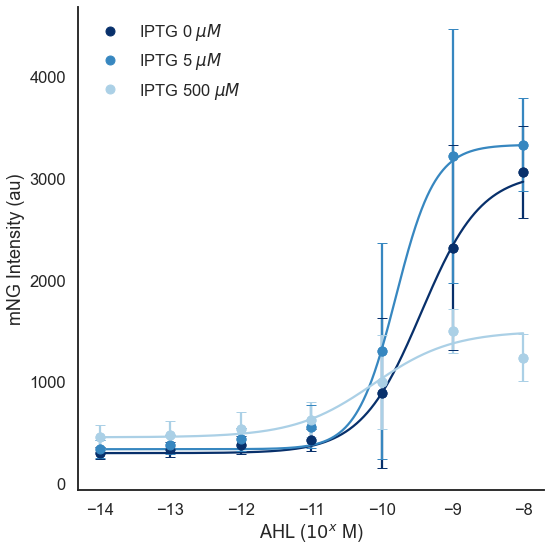

In [91]:
f, ax = plt.subplots(figsize=(8,8))
sns.set_context('talk')
sns.set_style('white')
colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']
plot_hill(mfi,std,[0,5,500],'LasR','Blues_r',ax)


f.tight_layout()
f.savefig('LasHill.png',dpi=600)

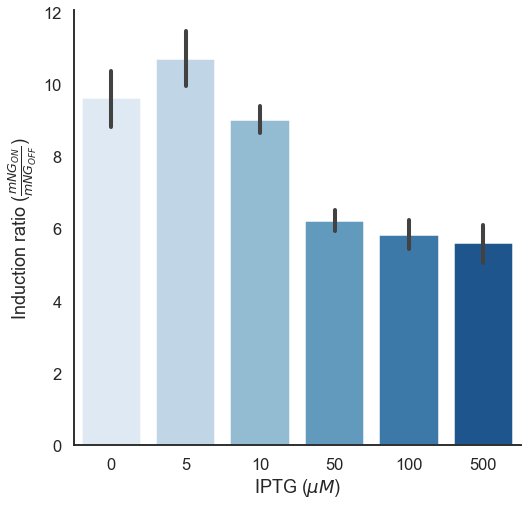

In [47]:
f, ax = plt.subplots(figsize=(8,8))
sns.set_context('talk')
sns.set_style('white')
sns.barplot(x='IPTG',y='R',data=mfi_rep,palette='Blues',ax=ax)
ax.set_xlabel(r'IPTG ($\mu M$)')
ax.set_ylabel(r'Induction ratio ($\frac{mNG_{ON}}{mNG_{OFF}}$)')
sns.despine()
#f.savefig('Lux ratio.png',dpi=600)

In [74]:
def plot_hill_params(mfi,Family,colormap,save=True,**kwargs):
    median_fluorescence = mfi[mfi.Family==Family]
    fit = get_hill_params(median_fluorescence,Family)
    f, axes = plt.subplots(nrows=3,figsize=(10,10),sharex=True)
    sns.set_context('talk')
    sns.set_style('white')
    sns.barplot(x='IPTG',y='R',data=median_fluorescence,palette=colormap,ax=axes[0])

    axes[0].set_ylabel(r'Induction ratio ($\frac{mNG_{ON}}{mNG_{OFF}}$)')
    sns.barplot(x='IPTG',y='EC50',data=fit,ax=axes[1],ci='sd',palette=colormap)
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$EC_{50}$')
    sns.barplot(x='IPTG',y='Slope',data=fit,ax=axes[2],ci='sd',palette=colormap)
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[2].set_xlabel(r'IPTG ($\mu M$)')
    f.align_ylabels()
    f.tight_layout()
    sns.despine()
    if save==True:
        f.savefig('Hill params {}.png'.format(Family),dpi=600)

<ipython-input-43-303073b6f702>:24: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-43-303073b6f702>:24: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-43-303073b6f702>:24: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-43-303073b6f702>:24: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-43-303073b6f702>:24: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-43-303073b6f702>:24: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-43-303073b6f7

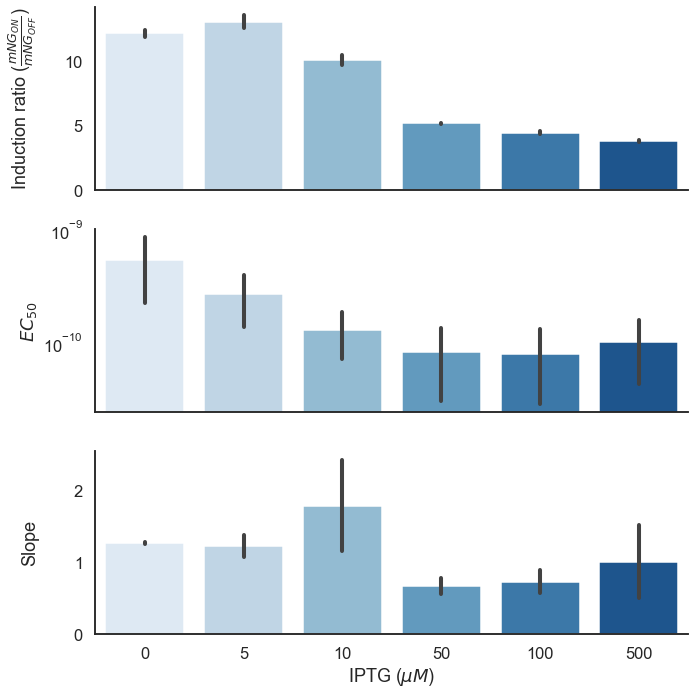

In [76]:
plot_hill_params(mfi,'LasR','Blues')